# Hubbard Model: A Tunable Model of Electron Correlation
**Evangeslista Group Rotation Project**

Brian Zhao, 10 Oct 2022

We first consider the simplest case, an open, one-dimensional Hubbard model. For an $N$-site $1$-D Hubbard model, we represent a configuration as
$$
|\mathbf{\text{n}}\rangle = |\underbrace{k_{1\uparrow}k_{2\uparrow}k_{3\uparrow}\dots k_{N\uparrow}}_{\text{alpha}}\underbrace{k_{1\downarrow}k_{2\downarrow}k_{3\downarrow}\dots k_{N\downarrow}}_{\text{beta}}\rangle
$$
where $k_i$ is the occupatation number of the $i$-th spinorbital.

In [1]:
import numpy as np
import scipy.special
from IPython.display import display, Math
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib widget

def get_excitation_level(f1, f2):
    """
    Get the excitation level between two bit strings f1 and f2, i.e., half the Hamming distance.
    """
    return int(count_set_bits(f1^f2)/2)    

def count_set_bits(f):
    """
    Return the number of set (1) bits in the bit string f.
    """
    return int(bin(f).count('1'))

def set_bit(f, bit_loc):
    """
    Set the bit_loc-th bit in bit string f. Returns unchanged if the bit is already set. bit_loc is zero-indexed.
    """
    return f | 1<<bit_loc

def clear_bit(f, bit_loc):
    """
    Unset the bit_loc-th bit in bit string f. Returns unchanged if the bit is already unset. bit_loc is zero-indexed.
    """
    return f & ~(1<<bit_loc)

def test_bit(f, bit_loc):
    """
    Test if bit_loc in f is set. Returns 1 if set, 0 if not set.
    """
    return (f & (1<<bit_loc)) >> bit_loc

def next_comb(n, k, comb):
    """
    Generate systematically the next combination of k objects in n bins. 
    comb is incremented like this:
    [0,1,2,...,k-1,k]
    [0,1,2,...,k-1,k+1]
    ...
    [0,1,2,...,k-1,n]
    [0,1,2,...,k,k+1]
    [0,1,2,...,k,k+2]
    ...
    """
    i = k-1
    comb[i] += 1
    
    while (comb[i] >= n - k + 1 + i):
        i -= 1
        if (i < 0):
            break
        comb[i] += 1
    
    if (comb[0] > n-k):
        ierr = 1
    else:
        ierr = 0
        for j in range(i+1, k):
            comb[j] = comb[j-1] + 1
            
    return ierr, comb

def occ_list_to_bit_string(occ_list):
    """
    Occupation list to bitstring.
    occ_list is of length n_el, the i-th element is the index of spinorbital occupied by the i-th electron.
    """
    bstring = 0
    for i in range(len(occ_list)):
        bstring = set_bit(bstring, occ_list[i])
    return bstring

class HubbardLattice1D:
    """
    The 1D Hubbard lattice with open boundary conditions.
    """
    def __init__(self, nsites, nalpha, nbeta, t, u, pbc=False, verbose=False):
        self.nsites = nsites
        self.bit_string_length = self.nsites*2
        self.nalpha = nalpha
        self.nbeta = nbeta
        self.nel = self.nalpha + self.nbeta
        self.t = t
        self.u = u
        self.ms = (nalpha-nbeta)/2.0
        self.pbc = pbc
        self.verbose = verbose
        
        self.alpha_mask = 0
        self.beta_mask = 0
        for i in range(self.nsites):
            self.alpha_mask = set_bit(self.alpha_mask, i)
            self.beta_mask = set_bit(self.beta_mask, i+self.nsites)
        
        self.nalpha_combinations = None
        self.nbeta_combinations = None
        self.ncomb = None
        self.mem_reqd_list = None
        self.mem_reqd_hamil = None
        self.alpha_strings = None
        self.beta_strings = None
        self.tot_strings = None
        self.hamil = None
        self.eigvals = None
        self.eigvecs = None
        self.occ_mat = None
        self.state_labels = None
        
        # Unlikely do be doing more than 32 sites for now..
        #self.bit_string_len = int(np.ceil(self.nsites*2/64))
        
    def creop(self, bit_string, spinorb):
        """
        Creation operator, creates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already occupied, sign is zero and the bit string is returned unchanged.
        """
        # If the bit is set then sgn = 0
        if ((bit_string>>(spinorb)) & 1):
            sgn = 0
        else:
            test_string = 0
            
            # if we have a beta creation operator, we need to 'hide' the alpha string
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = set_bit(bit_string, spinorb)
            if (spinorb >= self.nsites):
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = set_bit(bit_string, spinorb)

        return (sgn, bit_string)

    def annop(self, bit_string, spinorb):
        """
        Annihilation operator, annihilates spinorb in bit_string, returns the sign and the resulting bit string.
        If spinorb is already empty, sign is zero and the bit string is returned unchanged.
        """
        if ((bit_string>>(spinorb)) & 0):
            sgn = 0
        else:
            test_string = 0
            if (spinorb < self.nsites):
                for i in range(spinorb):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits(bit_string & test_string))
                bit_string = clear_bit(bit_string, spinorb)
            # if we have a beta annihilation operator, we need to 'hide' the alpha string
            else:
                for i in range(spinorb-self.nsites+1):
                    test_string = set_bit(test_string, i)
                sgn = (-1)**(count_set_bits((bit_string>>self.nsites) & test_string))
                bit_string = clear_bit(bit_string, spinorb)
        return (sgn, bit_string)


    def enumerate_states(self):
        """
        Enumerates all states of hl, only conserving Ms symmetry.
        """
        self.nalpha_combinations = int(scipy.special.binom(self.nsites, self.nalpha))
        self.nbeta_combinations = int(scipy.special.binom(self.nsites, self.nbeta))
        self.ncomb = self.nalpha_combinations * self.nbeta_combinations
        self.mem_reqd_list = self.ncomb*8/1e3 # We use 64-bit integers
        self.mem_reqd_hamil = (self.ncomb**2)*8/1e3

        if self.verbose:
            print(f"""There are {self.nalpha_combinations:d} alpha combinations,
{self.nbeta_combinations:d} beta combinations,
making a total of {self.ncomb:d} combinations,
requiring a memory of {self.mem_reqd_list:.2f} kB for the list of states,
and a memory of {self.mem_reqd_hamil:.2f} kB for the Hamiltonian, if requested.""")
        
        self.alpha_strings = np.zeros(self.nalpha_combinations, dtype='int64')
        self.beta_strings = np.zeros(self.nbeta_combinations, dtype='int64')
        self.tot_strings = np.zeros(self.ncomb, dtype='int64')

        comb = list(range(self.nalpha))
        self.alpha_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nalpha_combinations):
            ierr, comb = next_comb(self.nsites, self.nalpha, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.alpha_strings[i] = occ_list_to_bit_string(comb)

        comb = list(range(self.nbeta))
        self.beta_strings[0] = occ_list_to_bit_string(comb)
        for i in range(1,self.nbeta_combinations):
            ierr, comb = next_comb(self.nsites, self.nbeta, comb)
            if (ierr == 1):
                print('Too many combinations! Breaking.')
                break
            self.beta_strings[i] = occ_list_to_bit_string(comb)

        istring = 0
        for ialpha in range(self.nalpha_combinations):
            for ibeta in range(self.nbeta_combinations):
                self.tot_strings[istring] = ((self.beta_strings[ibeta])<<self.nsites) | (self.alpha_strings[ialpha])
                istring += 1
        
        self.get_occ_mat()
                
    def bit_string_to_occ_vec(self, bstring):
        ov_alpha = np.zeros(self.nsites, dtype='int32')
        ov_beta = np.zeros(self.nsites, dtype='int32')

        for i in range(self.nsites):
            ov_alpha[i] += (bstring>>i) & 1
            ov_beta[i] += (bstring>>(i+self.nsites)) & 1

        return ov_alpha, ov_beta, (ov_alpha+ov_beta)


    def generate_pretty_state_labels(self):
        self.state_labels = []
        for bstring in self.tot_strings:
            ov_alpha,ov_beta,_ = self.bit_string_to_occ_vec(bstring)
            string = '|'
            for i in range(self.nsites):
                if ov_alpha[i] == 0 and ov_beta[i] == 0:
                    string += '--'
                elif ov_alpha[i] == 1 and ov_beta[i] == 0:
                    string += '↑-'
                elif ov_alpha[i] == 0 and ov_beta[i] == 1:
                    string += '-↓'
                elif ov_alpha[i] == 1 and ov_beta[i] == 1:
                    string += '⇅'

                if i != self.nsites-1:
                    string += ','
                else:
                    string += '>'
            self.state_labels.append(string)
        
    def get_excitation_connection(self, f1, f2):
        """
        Get the bit location(s) of the set bits, given the number of set bits
        """
        excit_bstring = f1^f2 # 2 bits will be set if single excitation, which is the only type supported for now
        excit = [0,0] # excited from in f1, excited to in f2
        nbit_found = 0
        for i in range(self.bit_string_length):
            if (test_bit(excit_bstring, i)):
                # Check where this electron is coming from / going to
                if (test_bit(f1, i)):
                    excit[0] = i
                else:
                    excit[1] = i
                nbit_found += 1
                if (nbit_found == 2):
                    break
        return excit
                
    def pretty_print_states(self):
        print(f'There are {self.ncomb:d} states with {self.nalpha:d} alpha electrons and {self.nbeta:d} beta electrons in {self.nsites:d} sites.')
        self.generate_pretty_state_labels()
        for i in range(len(self.tot_strings)):
            print(f'{i:<5d}{self.state_labels[i]}')
            
    def get_hmatel(self, f1, f2):
        """
        <f1|H|f2>
        """
        hmatel = 0.0
        exlvl = get_excitation_level(f1, f2)
        if (exlvl > 1):
            hmatel = 0.0
        else:
            if (exlvl == 0):
                # Diagonal element
                beta_bstring = (f1 >> self.nsites)
                hmatel += self.u * count_set_bits(beta_bstring & f1)
            if (exlvl == 1):
                # Off-diagonal element
                excit = self.get_excitation_connection(f1, f2)
                if (abs(excit[0]-excit[1]) == 1):
                    sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                    hmatel -= sgn*self.t
                if (self.pbc and abs(excit[0]-excit[1]) == self.nsites-1):
                    sgn = self.annop(f1, excit[0])[0] * self.annop(f2, excit[1])[0]
                    hmatel -= sgn*self.t
        
        return hmatel
    
    def get_hamil(self):
        self.hamil = np.zeros((self.ncomb, self.ncomb))
        
        for i in range(self.ncomb):
            for j in range(i+1):
                self.hamil[i,j] = self.hamil[j,i] = self.get_hmatel(self.tot_strings[i],self.tot_strings[j])
                
    def solve_model(self):
        """
        Just a convenient wrapper
        """
        self.enumerate_states()
        self.get_hamil()
        self.eigvals, self.eigvecs = np.linalg.eigh(self.hamil)
        
    def plot_eigvecs(self):
        if (self.state_labels is None):
            self.generate_pretty_state_labels()
        f,ax = plt.subplots(figsize=(12,12))
        im = ax.imshow((self.eigvecs)**2)
        ax.set_yticks(list(range(self.ncomb)))
        ax.set_yticklabels(self.state_labels)
        f.colorbar(im,fraction=0.0455, pad=0.04, label=r'$|c_i|^2$')
        ax.set_title(r'${nsite}$-site, ${nel}$e, $M_s={ms}$ Hubbard model, $U/t={ut:.1f}$'.format(nsite=self.nsites, nel=self.nel, ms=self.ms, ut=float(self.u/self.t)))
        ax.set_xlabel('Eigenstate index')
        ax.set_ylabel('Many-body basis state')
        
    def get_occ_mat(self):
        self.occ_mat = np.zeros((self.ncomb,self.bit_string_length))
        for i in range(self.ncomb):
            oa, ob, _ = self.bit_string_to_occ_vec(self.tot_strings[i])
            self.occ_mat[i,::2] = oa
            self.occ_mat[i,1::2] = ob
            
    def plot_states(self):
        f,ax = plt.subplots(figsize=(8,8))
        ax.plot(self.eigvals,np.arange(self.ncomb),marker='x')
        ax.set_yticks(list(range(self.ncomb)))
        if (self.state_labels is None):
            self.generate_pretty_state_labels()
        ax.set_yticklabels(self.state_labels)


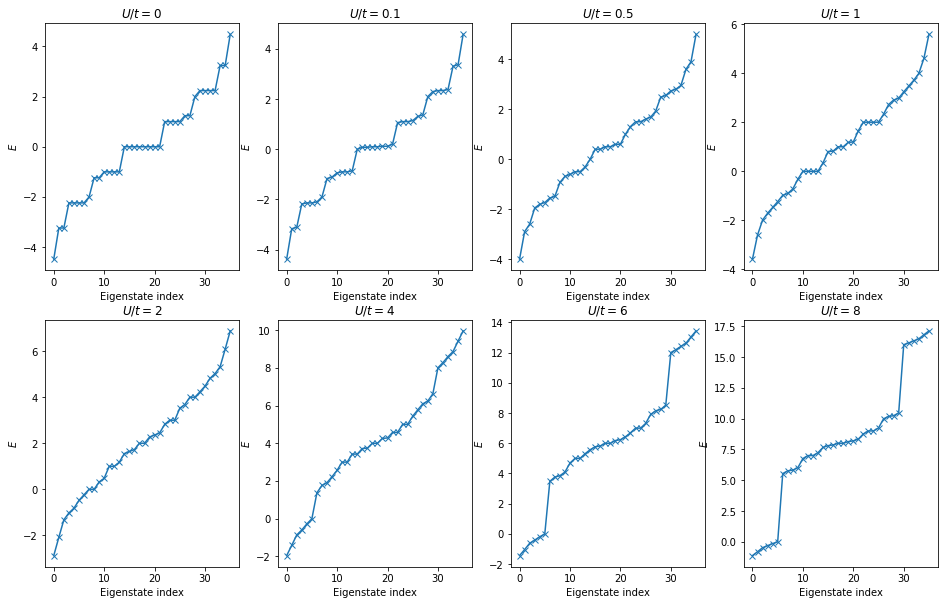

In [22]:
f,axes = plt.subplots(2,4,figsize=(16,10))

for i,u in enumerate([0,0.1,0.5,1,2,4,6,8]):
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.solve_model()
    axes.flatten()[i].plot(hl.eigvals,marker='x')
    axes.flatten()[i].set_title(r'$U/t={u}$'.format(u=u))
    axes.flatten()[i].set_xlabel('Eigenstate index')
    axes.flatten()[i].set_ylabel(r'$E$')

(-1.1, 0.1)

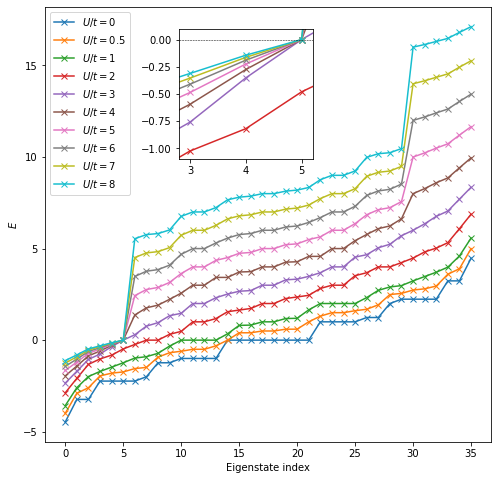

In [37]:
f,ax = plt.subplots(figsize=(8,8))
axins = ax.inset_axes([0.3,0.65,0.3,0.3])

for u in [0,0.5,1,2,3,4,5,6,7,8]:
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.solve_model()
    ax.plot(hl.eigvals,marker='x',label=r'$U/t={u}$'.format(u=u))
    axins.plot(hl.eigvals,marker='x')

ax.legend()
ax.set_xlabel('Eigenstate index')
ax.set_ylabel(r'$E$')
axins.axhline(y=0.0,c='k',ls='--',lw=0.5)
axins.set_xlim([2.8,5.2])
axins.set_ylim([-1.1,0.1])

Text(0, 0.5, 'Energy of the fifth excited state')

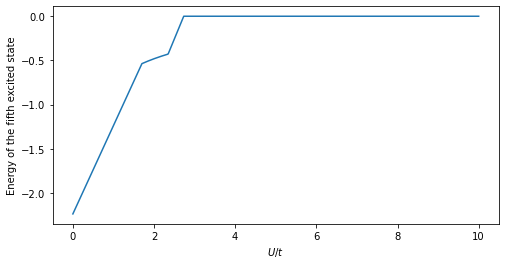

In [38]:
upoints = np.linspace(0,10,1000)
e6 = np.zeros(len(upoints))
for i, u in enumerate(upoints):
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.solve_model()
    e6[i] = hl.eigvals[5]
    
f,ax = plt.subplots(figsize=(8,4))
ax.plot(upoints,e6)
ax.set_xlabel(r'$U/t$')
ax.set_ylabel('Energy of the fifth excited state')

Text(0.5, 0, '$U/t$')

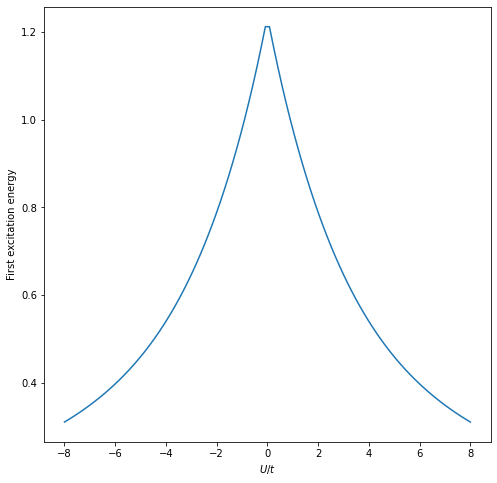

In [23]:
us = np.linspace(-8,8,100)
gap = np.zeros(len(us))

for i, u in enumerate(us):
    hl = HubbardLattice1D(4, 2, 2, 1, u)
    hl.solve_model()
    gap[i] = hl.eigvals[1] - hl.eigvals[0]

f,ax = plt.subplots(figsize=(8,8))
ax.plot(us,gap)
ax.set_ylabel('First excitation energy')
ax.set_xlabel(r'$U/t$')

## Testing ground below

In [4]:
hl = HubbardLattice1D(4,1,1,t=1,u=1)
hl.solve_model()
hl.pretty_print_states()

There are 16 states with 1 alpha electrons and 1 beta electrons in 4 sites.
0    |⇅,--,--,-->
1    |↑-,-↓,--,-->
2    |↑-,--,-↓,-->
3    |↑-,--,--,-↓>
4    |-↓,↑-,--,-->
5    |--,⇅,--,-->
6    |--,↑-,-↓,-->
7    |--,↑-,--,-↓>
8    |-↓,--,↑-,-->
9    |--,-↓,↑-,-->
10   |--,--,⇅,-->
11   |--,--,↑-,-↓>
12   |-↓,--,--,↑->
13   |--,-↓,--,↑->
14   |--,--,-↓,↑->
15   |--,--,--,⇅>


In [6]:
hl = HubbardLattice1D(4,2,2,t=1,u=1,pbc=True)
hl.solve_model()
hl.eigvals

array([-3.34084762e+00, -3.29295138e+00, -2.86387634e+00, -2.78526086e+00,
       -1.56155281e+00, -1.56155281e+00, -1.00000000e+00, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00, -5.61552813e-01, -5.61552813e-01,
        1.72740548e-16,  5.07690516e-01,  5.23028722e-01,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.47697128e+00,  1.49230948e+00,  2.00000000e+00,
        2.56155281e+00,  2.56155281e+00,  3.00000000e+00,  3.00000000e+00,
        3.00000000e+00,  3.00000000e+00,  3.56155281e+00,  3.56155281e+00,
        4.78526086e+00,  4.86387634e+00,  5.29295138e+00,  5.34084762e+00])

In [32]:
hl.beta_mask

240

In [20]:
def plot_scatter(t):
    psi = np.zeros(hl.ncomb)
    psi[0] = 1
    f, ax = plt.subplots(figsize=(8,2))
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.conjugate(psi)*psi
    weights = weights.astype('float64')

    ax.bar(np.arange(hl.ncomb),weights)
    ax.set_title(r't={t:.2f}'.format(t=t))
    ax.set_ylim([0,1])

In [21]:
interact(plot_scatter, t=(0,20,0.01))

interactive(children=(FloatSlider(value=10.0, description='t', max=20.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_scatter(t)>

In [3]:
hl = HubbardLattice1D(4,1,1,t=1,u=1)
hl.solve_model()
hl.pretty_print_states()

There are 16 states with 1 alpha electrons and 1 beta electrons in 4 sites.
0    |⇅,--,--,-->
1    |↑-,-↓,--,-->
2    |↑-,--,-↓,-->
3    |↑-,--,--,-↓>
4    |-↓,↑-,--,-->
5    |--,⇅,--,-->
6    |--,↑-,-↓,-->
7    |--,↑-,--,-↓>
8    |-↓,--,↑-,-->
9    |--,-↓,↑-,-->
10   |--,--,⇅,-->
11   |--,--,↑-,-↓>
12   |-↓,--,--,↑->
13   |--,-↓,--,↑->
14   |--,--,-↓,↑->
15   |--,--,--,⇅>


In [37]:
def plot_scatter(t):
    psi = np.zeros(hl.ncomb)
    psi[3] = 1
    f, ax = plt.subplots(figsize=(8,2))
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.dot((np.conjugate(psi)*psi), hl.occ_mat)
    weights = weights.astype('float64')

    ax.bar(np.arange(hl.bit_string_length),weights)
    ax.set_title(r't={t:.2f}'.format(t=t))
    ax.set_ylim([0,1])

In [38]:
interact(plot_scatter, t=(0,20,0.01))

interactive(children=(FloatSlider(value=10.0, description='t', max=20.0, step=0.01), Output()), _dom_classes=(…

<function __main__.plot_scatter(t)>

<ipython-input-5-9def5fd20f5e>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  states[:,i] = weights.astype('float64')


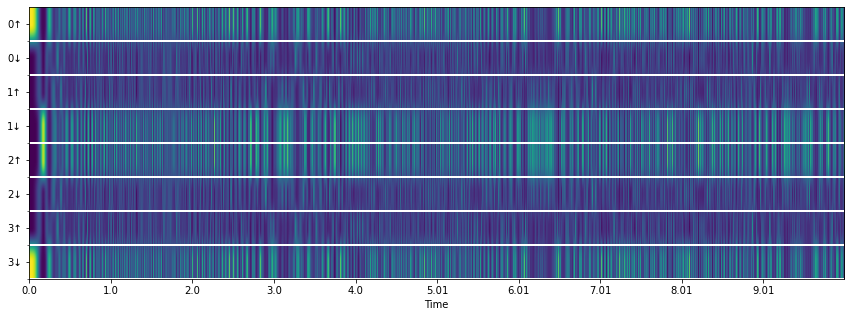

In [5]:
hl = HubbardLattice1D(4,1,1,t=1,u=1,pbc=True)
hl.solve_model()
psi = np.zeros(hl.ncomb)
psi[3] = 1
npoints = 1000

timepoints = np.linspace(0,10,npoints)
states = np.zeros((hl.bit_string_length,npoints))
for i, t in enumerate(timepoints):
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.dot((np.conjugate(psi)*psi), hl.occ_mat)
    states[:,i] = weights.astype('float64')
    
length = 15
height = 5
    
f, ax = plt.subplots(figsize=(length,height))
ax.imshow(states,aspect=float(npoints/hl.bit_string_length)*height/length)
xticks = np.arange(0,npoints,int(npoints/10))
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(timepoints[xticks],2))
ax.set_xlabel('Time')
ax.set_yticks(np.arange(hl.bit_string_length))
ax.set_yticklabels(['0↑','0↓','1↑','1↓','2↑','2↓','3↑','3↓',])
ax.set_yticks(np.arange(.5, hl.bit_string_length, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

In [18]:
hl.pretty_print_states()
hl.occ_mat

There are 16 states with 1 alpha electrons and 1 beta electrons in 4 sites.
0    |⇅,--,--,-->
1    |↑-,-↓,--,-->
2    |↑-,--,-↓,-->
3    |↑-,--,--,-↓>
4    |-↓,↑-,--,-->
5    |--,⇅,--,-->
6    |--,↑-,-↓,-->
7    |--,↑-,--,-↓>
8    |-↓,--,↑-,-->
9    |--,-↓,↑-,-->
10   |--,--,⇅,-->
11   |--,--,↑-,-↓>
12   |-↓,--,--,↑->
13   |--,-↓,--,↑->
14   |--,--,-↓,↑->
15   |--,--,--,⇅>


array([[1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.]])

<ipython-input-13-d74916ffca82>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  states[:,i] = weights.astype('float64')


Text(0, 0.5, 'Basis state index')

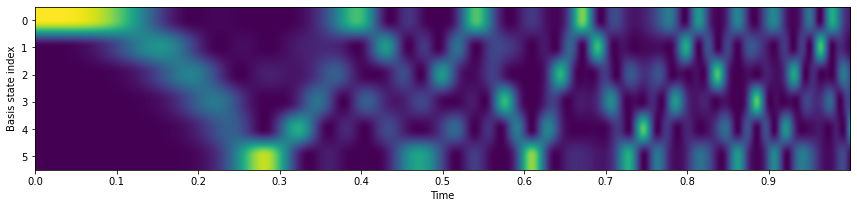

In [13]:
hl = HubbardLattice1D(6,1,0,t=0.1,u=1,pbc=False)
hl.solve_model()
psi = np.zeros(hl.ncomb)
psi[0] = 1
npoints = 1000

timepoints = np.linspace(0,1,npoints)
states = np.zeros((6,npoints))
for i, t in enumerate(timepoints):
    psi = (np.matmul(np.matmul(hl.eigvecs, np.diag(np.exp(-t*hl.eigvals*1j))), hl.eigvecs.T)).dot(psi)
    weights = np.conjugate(psi)*psi
    states[:,i] = weights.astype('float64')
    
length = 15
height = 3
    
f, ax = plt.subplots(figsize=(length,height))
ax.imshow(states,aspect=float(npoints/6)*height/length)
xticks = np.arange(0,npoints,int(npoints/10))
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(timepoints[xticks],2))
ax.set_xlabel('Time')
ax.set_ylabel('Basis state index')

In [10]:
np.arange(0,100+1,10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

[-2.26354285e+00 -1.00000000e+00 -4.14213562e-01 -3.81742244e-16
  7.55640076e-01  1.00000000e+00  2.00000000e+00  2.41421356e+00
  3.50790277e+00]
[-3.50790277e+00 -2.41421356e+00 -2.00000000e+00 -1.00000000e+00
 -7.55640076e-01  3.81742244e-16  4.14213562e-01  1.00000000e+00
  2.26354285e+00]


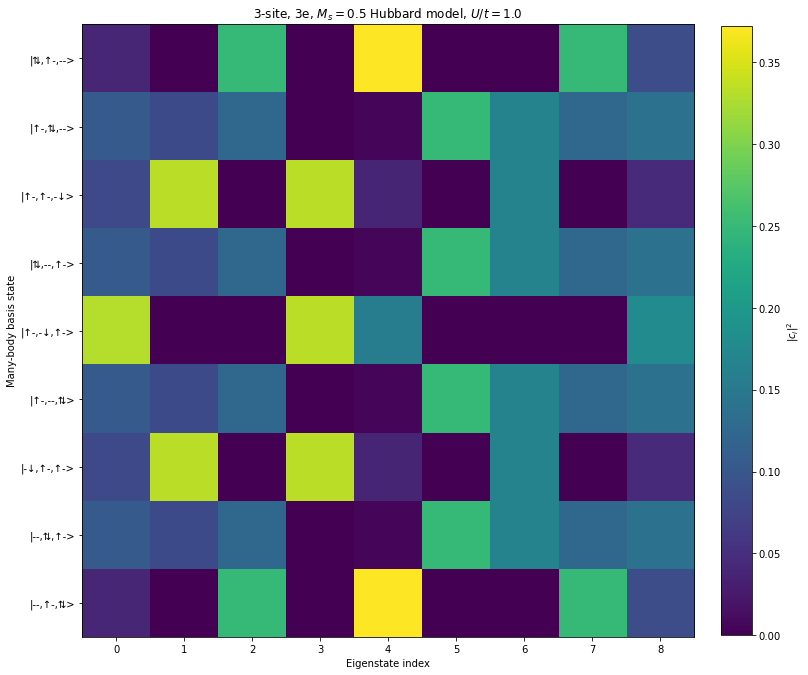

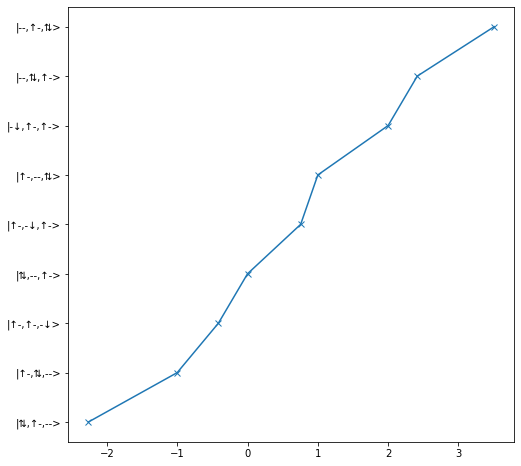

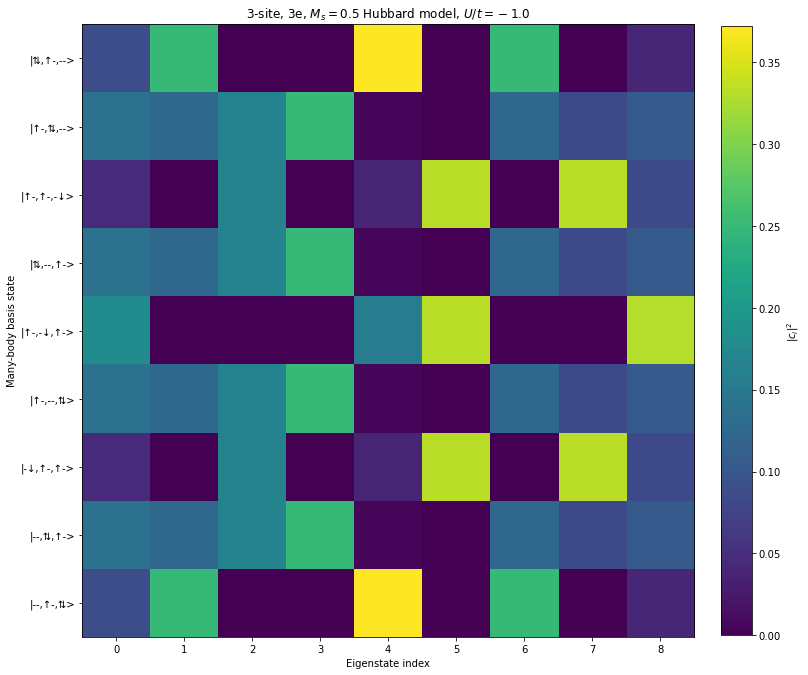

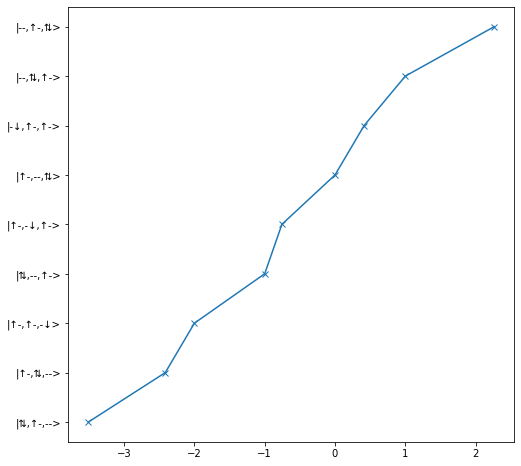

In [23]:
hl = HubbardLattice1D(3,2,1,1,1)
hl.solve_model()
hl.plot_eigvecs()
hl.plot_states()
print(hl.eigvals)
hl = HubbardLattice1D(3,2,1,1,-1)
hl.solve_model()
hl.plot_eigvecs()
hl.plot_states()
print(hl.eigvals)